# Sea-ice conditions during PS106

In [1]:
import os, sys
import datetime as dt
import numpy as np
import numpy.ma as ma

import matplotlib.pyplot as plt
import matplotlib.dates as dates
from matplotlib.collections import LineCollection

import cartopy
import cartopy.feature as cfeature
import cartopy.crs as ccrs

import tables as h5
from pyhdf import SD
import pyhdf.SD as SD

## get Polarstern positions

In [2]:
#18 Date/Time       Latitude        Longitude       Humidity spec [g/kg]    δ18O H2O vapour [‰ SMOW]        δD H2O vapour [‰ SMOW]  d xs [‰]

names = ['DateTime', 'Latitude', 'Longitude', 'Speed', 'Course']

srcfname1 = '/media/matthias/data3/PS_positions/PS106-1_link-to-mastertrack.tab'
psdata1 = np.recfromtxt(srcfname1, skip_header=19, names=names, encoding='utf8', converters={'DateTime':lambda s: dt.datetime.strptime(s, '%Y-%m-%dT%H:%M')})

srcfname2 = '/media/matthias/data3/PS_positions/PS106-2_link-to-mastertrack.tab'
psdata2 = np.recfromtxt(srcfname2, skip_header=19, names=names, encoding='utf8', converters={'DateTime':lambda s: dt.datetime.strptime(s, '%Y-%m-%dT%H:%M')})

srcfname3 = '/media/matthias/data3/PS_positions/PS107_link-to-mastertrack.tab'
psdata3 = np.recfromtxt(srcfname3, skip_header=19, names=names, encoding='utf8', converters={'DateTime':lambda s: dt.datetime.strptime(s, '%Y-%m-%dT%H:%M')})

psdata = np.concatenate((psdata1, psdata2, psdata3))

In [3]:
np.min(psdata['DateTime']), np.max(psdata['DateTime']), len(psdata)#, len(psdata[cond])

(datetime.datetime(2017, 5, 24, 10, 20),
 datetime.datetime(2017, 8, 19, 5, 59),
 11699)

In [4]:
ocean50m = cartopy.feature.NaturalEarthFeature('physical', 'ocean', '50m', edgecolor='None', facecolor='lightblue')
land50m = cartopy.feature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='None', facecolor='k')
crs = ccrs.NorthPolarStereo(central_longitude=-45,true_scale_latitude=70)


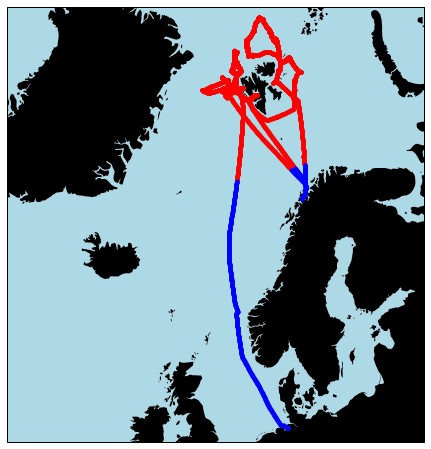

In [5]:
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(111, projection=ccrs.NorthPolarStereo(central_longitude=0,true_scale_latitude=70))
ax.set_extent([-25,25,53,85],crs=ccrs.PlateCarree())
ax.add_feature(ocean50m)
ax.add_feature(land50m)
latcond = psdata['Latitude']>72
ax.plot(psdata['Longitude'][latcond], psdata['Latitude'][latcond], 'r.', transform=ccrs.PlateCarree())
latcond = psdata['Latitude']<=72
ax.plot(psdata['Longitude'][latcond], psdata['Latitude'][latcond], 'b.', transform=ccrs.PlateCarree())

## Download Sea-Ice data

Svalbard maps from, e.g.:
https://seaice.uni-bremen.de/data/amsr2/asi_daygrid_swath/n3125/2017/may/Svalbard/asi-AMSR2-n3125-20170524-v5.hdf

Arctic maps from, e.g.:
https://seaice.uni-bremen.de/data/amsr2/asi_daygrid_swath/n3125/2017/may/Arctic3125/asi-AMSR2-n3125-20170501-v5.4.hdf

In [6]:
#icefolder = '/media/matthias/data3/amsr2_svalbard'
icefolder = '/media/matthias/data3/amsr2_arctic'

os.chdir(icefolder)
# download Avalbard sea ice data for PS106
d = np.min(psdata['DateTime'])
dmax = np.max(psdata['DateTime'])+dt.timedelta(days=1)
while d<=dmax:
    #server = 'https://seaice.uni-bremen.de/data/amsr2/asi_daygrid_swath/n3125/'+d.strftime('%Y/%b/').lower()+'Svalbard/'
    server = 'https://seaice.uni-bremen.de/data/amsr2/asi_daygrid_swath/n3125/'+d.strftime('%Y/%b/').lower()+'Arctic3125/'
    fname = d.strftime('asi-AMSR2-n3125-%Y%m%d-v5.hdf')
    if not os.path.exists(os.path.join(icefolder, fname)):
        print(os.path.join(server,fname))
        os.system('wget '+os.path.join(server,fname))        
    d+=dt.timedelta(days=1)
os.chdir('/home/matthias/sfit/notebooks/')

In [7]:
#griddata = SD.SD(os.path.join(icefolder, 'LongitudeLatitudeGrid-n3125-Svalbard.hdf'))
griddata = SD.SD(os.path.join(icefolder, 'LongitudeLatitudeGrid-n3125-Arctic3125.hdf'))

asigridlat = griddata.select('Latitudes')
latitudes = asigridlat.get()
latitudes = ma.masked_less(latitudes, 0)

asigridlon = griddata.select('Longitudes')
longitudes = asigridlon.get()
longitudes = longitudes%180

griddata.end()

data = SD.SD(os.path.join(icefolder, 'asi-AMSR2-n3125-20170524-v5.hdf'))
#print(data2.datasets())
asi = data.select('ASI Ice Concentration')
concentration = asi.get()
concentration = ma.masked_less(concentration, 1)
data.end()


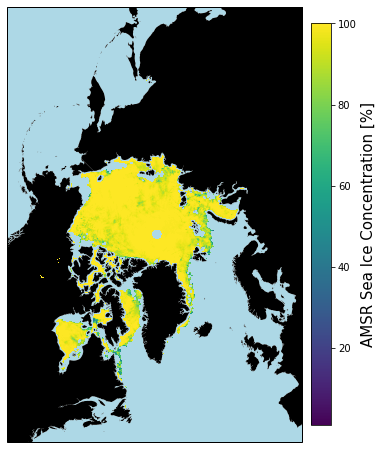

In [8]:
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(111, projection=crs)
#ax = fig.add_subplot(111, projection=ccrs.NorthPolarStereo(central_longitude=0,true_scale_latitude=70))
ax.add_feature(ocean50m)
ax.add_feature(land50m)
#ax.set_extent([-25,25,53,85], crs=ccrs.PlateCarree())
ax.set_extent([-3850000,3750000,-5350000,5850000], crs=crs)
im = ax.imshow(concentration, extent=[-3850000,3750000,-5350000,5850000], transform=crs, zorder=30)
ax.set_aspect(1)
cb = fig.colorbar(im, ax=ax, fraction=0.024, pad=0.01)
cb.set_label('AMSR Sea Ice Concentration [%]', fontsize=15)

## Get sea-ice cover for each day and position

In [9]:
def geticedata(d):
    data = SD.SD(os.path.join(icefolder, 'asi-AMSR2-n3125-'+d.strftime('%Y%m%d')+'-v5.hdf'))
    asi = data.select('ASI Ice Concentration')
    concentration = asi.get()
    #concentration = ma.masked_less(concentration, 1)
    data.end()
    return concentration.data

In [10]:
mindate = dt.datetime(2017,5,24)
maxdate = dt.datetime(2017,8,19)

ds = []
meanconc = []
latconc = []
lonconc = []
lats = []
lons = []

d = mindate 
while d<=maxdate:
    #print(d)
    datecond = (psdata['DateTime']>=d) & (psdata['DateTime']<d+dt.timedelta(days=1))
    if np.any(datecond):
        meanlat = np.mean(psdata['Latitude'][datecond][~np.isnan(psdata['Latitude'][datecond])])
        meanlon = np.mean(psdata['Longitude'][datecond][~np.isnan(psdata['Longitude'][datecond])])
        minlat = np.min(psdata['Latitude'][datecond][~np.isnan(psdata['Latitude'][datecond])])
        minlon = np.min(psdata['Longitude'][datecond][~np.isnan(psdata['Longitude'][datecond])])
        maxlat = np.max(psdata['Latitude'][datecond][~np.isnan(psdata['Latitude'][datecond])])
        maxlon = np.max(psdata['Longitude'][datecond][~np.isnan(psdata['Longitude'][datecond])])
        #print(d, meanlat, meanlon)
        lats.append(meanlat)
        lons.append(meanlon)
        latcond = (latitudes>minlat) & (latitudes<maxlat)
        loncond = (longitudes>minlon) & (longitudes<maxlon)
        concentration = geticedata(d)
        con = np.where((latcond & loncond), concentration, np.nan)
        ds.append(d)
        if len(con[~np.isnan(con)])>0:
            meanconc.append(np.mean(con[~np.isnan(con)]))
            latconc.append((minlat, maxlat))
            lonconc.append((minlon, maxlon))
        else:
            meanconc.append(np.nan)
    else:
        print(d)
    d+=dt.timedelta(days=1)

meanconc = np.array(meanconc)
ds = np.array(ds)
lats = np.array(lats)
lons = np.array(lons)

2017-06-22 00:00:00
2017-07-21 00:00:00
2017-07-22 00:00:00


In [11]:
#for i, j, k in zip(ds, latconc, lonconc):
#    print(i, j, k)

## Plotting results

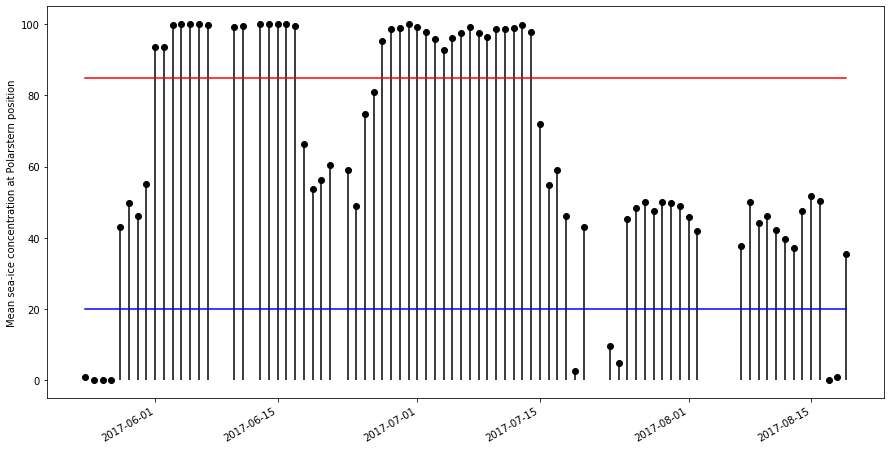

In [13]:
fig, ax = plt.subplots(1, figsize=(15,8))
ax.set_ylabel('Mean sea-ice concentration at Polarstern position')
ax.plot(ds, meanconc, 'ko')
ax.vlines(ds, ymin=0, ymax=meanconc)
ax.plot([np.min(ds), np.max(ds)], [85,85], 'r-')
ax.plot([np.min(ds), np.max(ds)], [20,20], 'b-')
fig.autofmt_xdate()

/home/matthias/py3/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less
/home/matthias/py3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in greater
/home/matthias/py3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in less_equal
/home/matthias/py3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater_equal


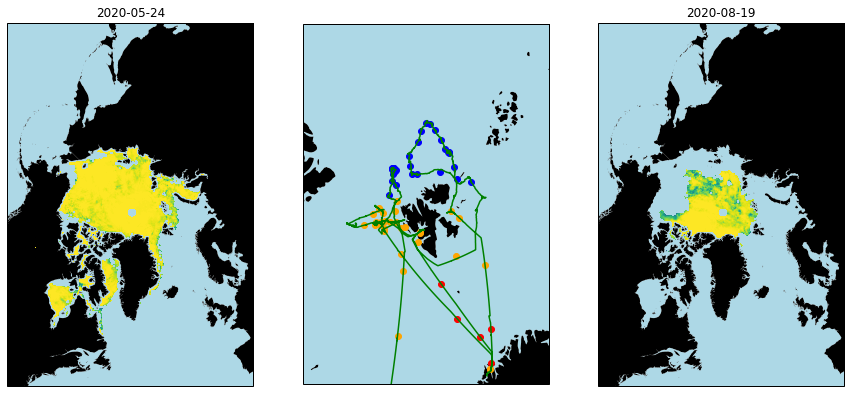

In [43]:
#land110m = cartopy.feature.NaturalEarthFeature('physical', 'land', '110m', edgecolor='None', facecolor='k')
land50m = cartopy.feature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='None', facecolor='k')
crs = ccrs.NorthPolarStereo(central_longitude=-45,true_scale_latitude=70)

data = SD.SD(os.path.join(icefolder, 'asi-AMSR2-n3125-20170524-v5.hdf'))
#print(data2.datasets())
asi = data.select('ASI Ice Concentration')
concentration1 = asi.get()
concentration1 = ma.masked_less(concentration1, 1)
data.end()


data = SD.SD(os.path.join(icefolder, 'asi-AMSR2-n3125-20170819-v5.hdf'))
#print(data2.datasets())
asi = data.select('ASI Ice Concentration')
concentration2 = asi.get()
concentration2 = ma.masked_less(concentration, 1)
data.end()


fig = plt.figure(figsize=(15, 8))
ax1 = fig.add_subplot(131, projection=crs)
ax1.set_title('2020-05-24')
ax1.add_feature(ocean50m)
ax1.add_feature(land50m)
ax1.set_extent([-3850000,3750000,-5350000,5850000], crs=crs)
im = ax1.imshow(concentration1, extent=[-3850000,3750000,-5350000,5850000], transform=crs, zorder=30)

ax3 = fig.add_subplot(133, projection=crs)
ax3.set_title('2020-08-19')
ax3.add_feature(ocean50m)
ax3.add_feature(land50m)
ax3.set_extent([-3850000,3750000,-5350000,5850000], crs=crs)
im = ax3.imshow(concentration2, extent=[-3850000,3750000,-5350000,5850000], transform=crs, zorder=30)


ax2 = fig.add_subplot(132, projection=ccrs.NorthPolarStereo(central_longitude=0,true_scale_latitude=70))
ax2.add_feature(ocean50m)
ax2.add_feature(land50m)
ax2.set_extent([-10,30,70,90],crs=ccrs.PlateCarree())
#im = ax.imshow(concentration, extent=[np.min(longitudes), np.max(longitudes), np.min(latitudes), np.max(latitudes)], transform=crs, zorder=0)
cond = meanconc<20
ax2.plot(lons[cond], lats[cond], 'ro', transform=ccrs.PlateCarree())
cond = meanconc>85
ax2.plot(lons[cond], lats[cond], 'bo', transform=ccrs.PlateCarree())
cond = (meanconc<=70) & (meanconc>=20)
ax2.plot(lons[cond], lats[cond], 'o', color='orange', transform=ccrs.PlateCarree())
ax2.plot(psdata['Longitude'], psdata['Latitude'], 'g-', transform=ccrs.PlateCarree())
#cb = fig.colorbar(im, ax=ax, fraction=0.024, pad=0.01)
#cb.set_label('AMSR Sea Ice Concentration [%]', fontsize=15)